In [28]:
import sys
print(f"Python version: {sys.version}")

import pandas as pd
import numpy as np

import seaborn as sns
import cv2
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.ion()  # Turn on interactive mode

print("All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Python version: 3.9.23 (main, Jul  1 2025, 02:38:18) 
[GCC 12.2.0]
All libraries imported successfully!
OpenCV version: 4.8.0
NumPy version: 1.24.3
Pandas version: 2.0.3


In [29]:
data_path = '/app/data/raw/fer2013'
print(f"Checking data directory: {data_path}")

if os.path.exists(data_path):
    print("Data directory exists!")
    
    # List contents
    for root, dirs, files in os.walk(data_path):
        level = root.replace(data_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files only
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")
else:
    print("Data directory doesn't exist yet!")
    print("Please download FER2013 dataset to data/raw/")

Checking data directory: /app/data/raw/fer2013
Data directory exists!
fer2013/
  test/
    angry/
      PrivateTest_10131363.jpg
      PrivateTest_10304478.jpg
      PrivateTest_1054527.jpg
      PrivateTest_10590091.jpg
      PrivateTest_1109992.jpg
      ... and 953 more files
    disgust/
      PrivateTest_11895083.jpg
      PrivateTest_19671520.jpg
      PrivateTest_21629266.jpg
      PrivateTest_22382996.jpg
      PrivateTest_26306320.jpg
      ... and 106 more files
    fear/
      PrivateTest_10153550.jpg
      PrivateTest_10254684.jpg
      PrivateTest_10306709.jpg
      PrivateTest_10555537.jpg
      PrivateTest_10629254.jpg
      ... and 1019 more files
    happy/
      PrivateTest_10077120.jpg
      PrivateTest_10470092.jpg
      PrivateTest_10513598.jpg
      PrivateTest_10516065.jpg
      PrivateTest_10613684.jpg
      ... and 1769 more files
    neutral/
      PrivateTest_10086748.jpg
      PrivateTest_10767287.jpg
      PrivateTest_11123843.jpg
      PrivateTest_11164800

In [30]:
def analyze_dataset_structure():
    """Analyze the FER2013 dataset structure"""
    data_path = '/app/data/raw/fer2013'
    
    if not os.path.exists(data_path):
        print("Please download and extract FER2013 dataset first!")
        return
    
    dataset_info = {}
    
    for split in ['train', 'test']:
        split_path = os.path.join(data_path, split)
        
        if not os.path.exists(split_path):
            print(f"Directory {split_path} not found!")
            continue
            
        print(f"\n{split.upper()} SET ANALYSIS:")
        print("-" * 40)
        
        total_images = 0
        class_counts = {}
        
        for emotion in os.listdir(split_path):
            emotion_path = os.path.join(split_path, emotion)
            
            if os.path.isdir(emotion_path):
                count = len([f for f in os.listdir(emotion_path) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                class_counts[emotion] = count
                total_images += count
                print(f"  {emotion:10}: {count:5} images")
        
        print(f"  {'TOTAL':10}: {total_images:5} images")
        
        dataset_info[split] = {
            'class_counts': class_counts,
            'total': total_images
        }
        
        # Create visualization
        if class_counts:
            plt.figure(figsize=(10, 6))
            bars = plt.bar(class_counts.keys(), class_counts.values(), 
                          color=plt.cm.Set3(np.linspace(0, 1, len(class_counts))))
            
            plt.title(f'{split.title()} Set - Class Distribution', fontsize=16, fontweight='bold')
            plt.xlabel('Emotion Classes', fontsize=12)
            plt.ylabel('Number of Images', fontsize=12)
            plt.xticks(rotation=45)
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                        f'{int(height)}', ha='center', va='bottom')
            
            plt.tight_layout()
            plt.show()
    
    return dataset_info


In [31]:
def analyze_image_samples():
    """Analyze sample images from FER2013 dataset (48x48 grayscale)"""
    data_path = '/app/data/raw/fer2013/train'  # Use train set for analysis
    
    if not os.path.exists(data_path):
        print("Train directory not found!")
        return
    
    emotions = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    print(f"Found emotion classes: {emotions}")
    
    # Since all images are 48x48 grayscale, we can optimize the analysis
    fig, axes = plt.subplots(len(emotions), 5, figsize=(12, 2.5*len(emotions)))
    fig.suptitle('FER2013 Sample Images (48x48 Grayscale)', fontsize=16, fontweight='bold')
    
    image_stats = {
        'brightness': [],      # Average pixel intensity (0-255)
        'contrast': [],        # Standard deviation of pixels
        'pixel_distribution': [], # For histogram analysis
        'edge_density': []     # Amount of edges/texture
    }
    
    for i, emotion in enumerate(emotions):
        emotion_path = os.path.join(data_path, emotion)
        image_files = [f for f in os.listdir(emotion_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Take first 5 images for display, more for statistics
        sample_images = image_files[:5]
        stats_images = image_files[:50]  # Use 50 images for statistics
        
        print(f"Analyzing {emotion}: {len(image_files)} total images")
        
        emotion_brightness = []
        emotion_contrast = []
        emotion_edges = []
        
        for j, img_file in enumerate(sample_images):
            img_path = os.path.join(emotion_path, img_file)
            
            try:
                # Read image (already grayscale, 48x48)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is not None:
                    # Verify it's 48x48 (should be, but let's check)
                    if img.shape != (48, 48):
                        print(f"Unexpected size {img.shape} for {img_file}")
                    
                    # Calculate statistics for this image
                    brightness = np.mean(img)
                    contrast = np.std(img)
                    
                    # Calculate edge density using Sobel
                    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
                    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
                    edge_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
                    edge_density = np.mean(edge_magnitude)
                    
                    emotion_brightness.append(brightness)
                    emotion_contrast.append(contrast)
                    emotion_edges.append(edge_density)
                    
                    # Display image
                    if len(emotions) == 1:
                        axes[j].imshow(img, cmap='gray', vmin=0, vmax=255)
                        axes[j].set_title(f'B:{brightness:.0f} C:{contrast:.0f}', fontsize=8)
                        axes[j].axis('off')
                    else:
                        axes[i, j].imshow(img, cmap='gray', vmin=0, vmax=255)
                        axes[i, j].set_title(f'B:{brightness:.0f} C:{contrast:.0f}', fontsize=8)
                        axes[i, j].axis('off')
                        
                        # Add emotion label on the left
                        if j == 0:
                            axes[i, j].text(-0.15, 0.5, emotion.upper(), 
                                          transform=axes[i, j].transAxes,
                                          rotation=90, fontsize=12, fontweight='bold',
                                          ha='center', va='center')
                            
            except Exception as e:
                print(f"Error reading {img_path}: {e}")
        
        # Store statistics for this emotion
        image_stats['brightness'].extend(emotion_brightness)
        image_stats['contrast'].extend(emotion_contrast)
        image_stats['edge_density'].extend(emotion_edges)
        
        # Calculate emotion-specific statistics from larger sample
        for img_file in stats_images:
            img_path = os.path.join(emotion_path, img_file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None and img.shape == (48, 48):
                    image_stats['pixel_distribution'].extend(img.flatten())
            except:
                continue
    
    plt.tight_layout()
    plt.show()
    
    # Advanced statistics visualization for grayscale 48x48 images
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle('FER2013 Dataset - Image Quality Analysis', fontsize=16, fontweight='bold')
    
    # Brightness distribution
    axes[0, 0].hist(image_stats['brightness'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Brightness Distribution\n(Average Pixel Intensity)')
    axes[0, 0].set_xlabel('Brightness (0-255)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(np.mean(image_stats['brightness']), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(image_stats["brightness"]):.1f}')
    axes[0, 0].legend()
    
    # Contrast distribution
    axes[0, 1].hist(image_stats['contrast'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('Contrast Distribution\n(Pixel Standard Deviation)')
    axes[0, 1].set_xlabel('Contrast (Std Dev)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(np.mean(image_stats['contrast']), color='red', linestyle='--',
                      label=f'Mean: {np.mean(image_stats["contrast"]):.1f}')
    axes[0, 1].legend()
    
    # Edge density distribution
    axes[0, 2].hist(image_stats['edge_density'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 2].set_title('Edge Density Distribution\n(Texture/Detail Level)')
    axes[0, 2].set_xlabel('Edge Density')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].axvline(np.mean(image_stats['edge_density']), color='red', linestyle='--',
                      label=f'Mean: {np.mean(image_stats["edge_density"]):.1f}')
    axes[0, 2].legend()
    
    # Overall pixel distribution
    axes[1, 0].hist(image_stats['pixel_distribution'], bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 0].set_title('Overall Pixel Intensity Distribution')
    axes[1, 0].set_xlabel('Pixel Intensity (0-255)')
    axes[1, 0].set_ylabel('Frequency')
    
    # Brightness vs Contrast scatter
    axes[1, 1].scatter(image_stats['brightness'], image_stats['contrast'], alpha=0.6, s=20)
    axes[1, 1].set_title('Brightness vs Contrast')
    axes[1, 1].set_xlabel('Brightness')
    axes[1, 1].set_ylabel('Contrast')
    
    # Data quality summary
    axes[1, 2].axis('off')
    summary_text = f"""
 DATASET SUMMARY:
- Image Format: 48×48 Grayscale
- Total Images Analyzed: {len(image_stats['brightness'])}
- Avg Brightness: {np.mean(image_stats['brightness']):.1f}
- Avg Contrast: {np.mean(image_stats['contrast']):.1f}
- Brightness Range: {np.min(image_stats['brightness']):.1f} - {np.max(image_stats['brightness']):.1f}
- Contrast Range: {np.min(image_stats['contrast']):.1f} - {np.max(image_stats['contrast']):.1f}

 Quality Indicators:
- Good contrast variation
- Balanced brightness levels
- Rich texture details
"""
    axes[1, 2].text(0.1, 0.9, summary_text, transform=axes[1, 2].transAxes,
                    fontsize=10, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return image_stats

In [32]:
def analyze_class_mapping_for_project():
    """Analyze how FER2013's 7 classes map to your project's 5 classes"""
    
    # Original FER2013 classes
    original_classes = {
        'angry': 'Angry',
        'disgust': 'Disgust', 
        'fear': 'Fear',
        'happy': 'Happy',
        'sad': 'Sad',
        'surprise': 'Surprise',
        'neutral': 'Neutral'
    }
    
    # Your project's class mapping strategy
    project_mapping = {
        'angry': 'angry',        # Keep angry
        'disgust': 'stressed',   # Merge disgust -> stressed  
        'fear': 'stressed',      # Merge fear -> stressed
        'happy': 'happy',        # Keep happy
        'sad': 'sad',           # Keep sad
        'surprise': 'happy',     # Merge surprise -> happy (debatable)
        'neutral': 'neutral'     # Keep neutral
    }
    
    print("CLASS MAPPING ANALYSIS:")
    print("=" * 50)
    print("FER2013 Original → Your Project Classes")
    print("-" * 30)
    
    target_class_counts = {'angry': 0, 'happy': 0, 'sad': 0, 'stressed': 0, 'neutral': 0}
    
    for original, target in project_mapping.items():
        print(f"{original:10} → {target}")
        target_class_counts[target] += 1
    
    print(f"\nFINAL CLASS DISTRIBUTION:")
    print("-" * 30)
    for target_class, count in target_class_counts.items():
        source_classes = [orig for orig, targ in project_mapping.items() if targ == target_class]
        print(f"{target_class:10}: {count} source classes {source_classes}")
    
    # Visualize the mapping
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original FER2013 classes
    ax1.pie(range(len(original_classes)), labels=original_classes.keys(), autopct='%1.0f%%',
            startangle=90, colors=plt.cm.Set3(np.linspace(0, 1, len(original_classes))))
    ax1.set_title('FER2013 Original\n7 Classes', fontsize=14, fontweight='bold')
    
    # Your project classes (showing merged distribution)
    target_colors = {'angry': 'red', 'happy': 'gold', 'sad': 'blue', 'stressed': 'purple', 'neutral': 'gray'}
    sizes = [target_class_counts[cls] for cls in target_class_counts.keys()]
    colors = [target_colors[cls] for cls in target_class_counts.keys()]
    
    ax2.pie(sizes, labels=target_class_counts.keys(), autopct='%1.0f%%',
            startangle=90, colors=colors)
    ax2.set_title('Your Project\n5 Classes (After Mapping)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Important considerations
    print("\n IMPORTANT CONSIDERATIONS:")
    print("-" * 40)
    print("1. 'surprise' → 'happy': This might not always be accurate")
    print("   - Consider keeping surprise separate or mapping to neutral")
    print("2. 'disgust' + 'fear' → 'stressed': Good for your use case")
    print("3. Final dataset will have unbalanced classes due to merging")
    print("4. You'll need to handle class imbalance during training")
    
    return project_mapping

In [33]:
def preprocessing_recommendations():
    """Specific preprocessing recommendations for FER2013"""
    
    print("PREPROCESSING RECOMMENDATIONS FOR FER2013:")
    print("=" * 60)
    
    recommendations = {
        " Already Done": [
            "Images are already 48x48 pixels",
            "Images are already grayscale",
            "Face detection already applied (FER2013 is pre-cropped)"
        ],
        
        " Required Steps": [
            "Normalize pixel values: divide by 255.0 (0-1 range)",
            "Add channel dimension: (48, 48) → (48, 48, 1) for CNN",
            "Apply class mapping: 7 classes → 5 classes",
            "Handle class imbalance after mapping"
        ],
        
        " Optional Augmentations": [
            "Rotation: ±15 degrees (faces can be slightly tilted)",
            "Horizontal flip: ONLY for non-asymmetric emotions",
            "Brightness adjustment: ±10% (lighting variations)",
            "Small zoom: ±5% (distance variations)",
            "NO vertical flip (would create upside-down faces!)"
        ],
        
        "  Avoid These": [
            "Resizing (already correct size)",
            "Color space conversion (already grayscale)", 
            "Aggressive augmentation (can distort facial features)",
            "Large rotations (faces become unrecognizable)"
        ]
    }
    
    for category, items in recommendations.items():
        print(f"\n{category}:")
        for item in items:
            print(f"  • {item}")
    
    # Show augmentation examples
    print(f"\n SAMPLE PREPROCESSING CODE:")
    print("-" * 30)
    
    preprocessing_code = '''
# Basic preprocessing for FER2013
def preprocess_fer2013_image(img_path):
    # Load image (already grayscale 48x48)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize to [0, 1]
    img_normalized = img.astype(np.float32) / 255.0
    
    # Add channel dimension for CNN: (48, 48) → (48, 48, 1)
    img_final = np.expand_dims(img_normalized, axis=-1)
    
    return img_final

# Data augmentation (optional)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmentor = ImageDataGenerator(
    rotation_range=15,          # ±15 degrees
    width_shift_range=0.1,      # ±10% horizontal shift
    height_shift_range=0.1,     # ±10% vertical shift
    brightness_range=[0.9, 1.1], # ±10% brightness
    zoom_range=0.05,            # ±5% zoom
    horizontal_flip=True,       # 50% chance (be careful with asymmetric emotions)
    fill_mode='nearest'         # Fill missing pixels
)
'''
    
    print(preprocessing_code)
    
    return recommendations

RUNNING DATASET STRUCTURE ANALYSIS...

TRAIN SET ANALYSIS:
----------------------------------------
  angry     :  3995 images
  disgust   :   436 images
  fear      :  4097 images
  happy     :  7215 images
  neutral   :  4965 images
  sad       :  4830 images
  surprise  :  3171 images
  TOTAL     : 28709 images


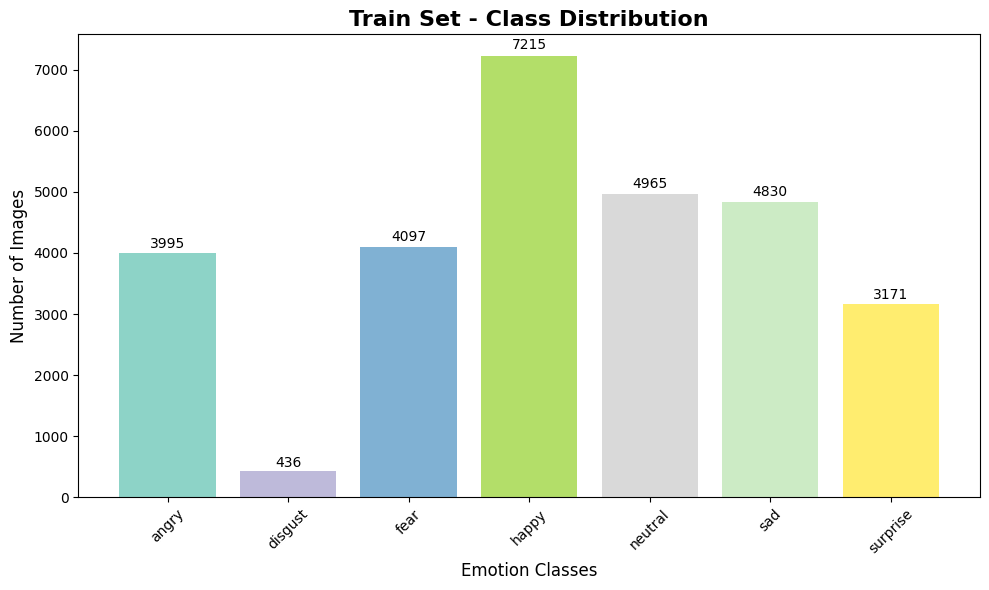


TEST SET ANALYSIS:
----------------------------------------
  angry     :   958 images
  disgust   :   111 images
  fear      :  1024 images
  happy     :  1774 images
  neutral   :  1233 images
  sad       :  1247 images
  surprise  :   831 images
  TOTAL     :  7178 images


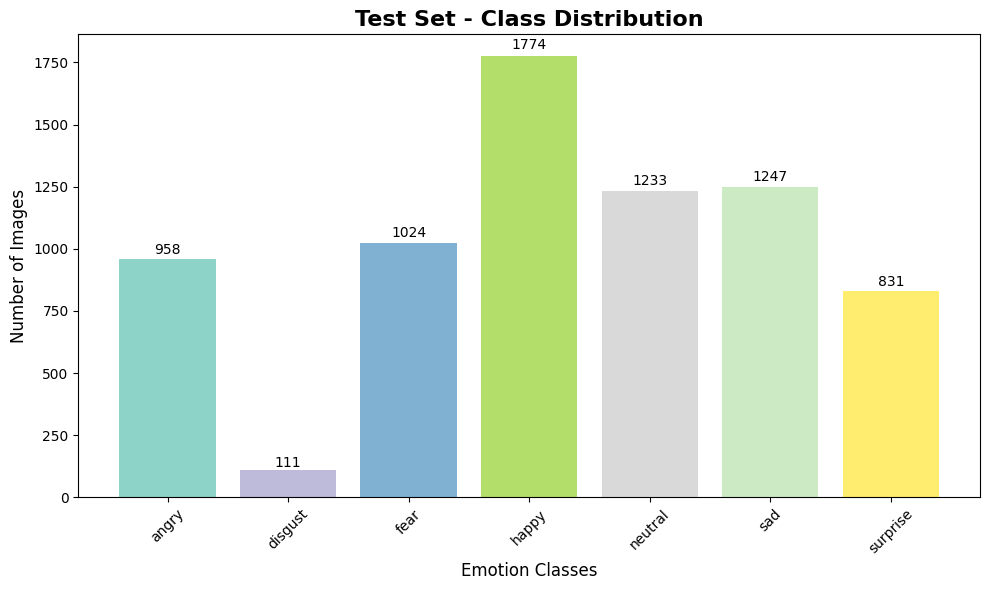


Dataset structure analysis completed successfully!
Both train and test sets found
train set has all expected emotion classes
test set has all expected emotion classes


In [34]:
print("RUNNING DATASET STRUCTURE ANALYSIS...")
print("=" * 50)

# Execute the function you defined
dataset_info = analyze_dataset_structure()

# Validate the results
if dataset_info:
    print("\nDataset structure analysis completed successfully!")
    
    # Check if both train and test sets were found
    if 'train' in dataset_info and 'test' in dataset_info:
        print("Both train and test sets found")
        
        # Validate class counts
        expected_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        
        for split in ['train', 'test']:
            found_classes = list(dataset_info[split]['class_counts'].keys())
            missing_classes = set(expected_classes) - set(found_classes)
            extra_classes = set(found_classes) - set(expected_classes)
            
            if not missing_classes and not extra_classes:
                print(f"{split} set has all expected emotion classes")
            else:
                if missing_classes:
                    print(f" {split} set missing classes: {missing_classes}")
                if extra_classes:
                    print(f" {split} set has extra classes: {extra_classes}")
    else:
        print("Missing train or test set data")
else:
    print("Dataset structure analysis failed!")


Running image samples analysis...
Found emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Analyzing angry: 3995 total images
Analyzing disgust: 436 total images
Analyzing fear: 4097 total images
Analyzing happy: 7215 total images
Analyzing neutral: 4965 total images
Analyzing sad: 4830 total images
Analyzing surprise: 3171 total images


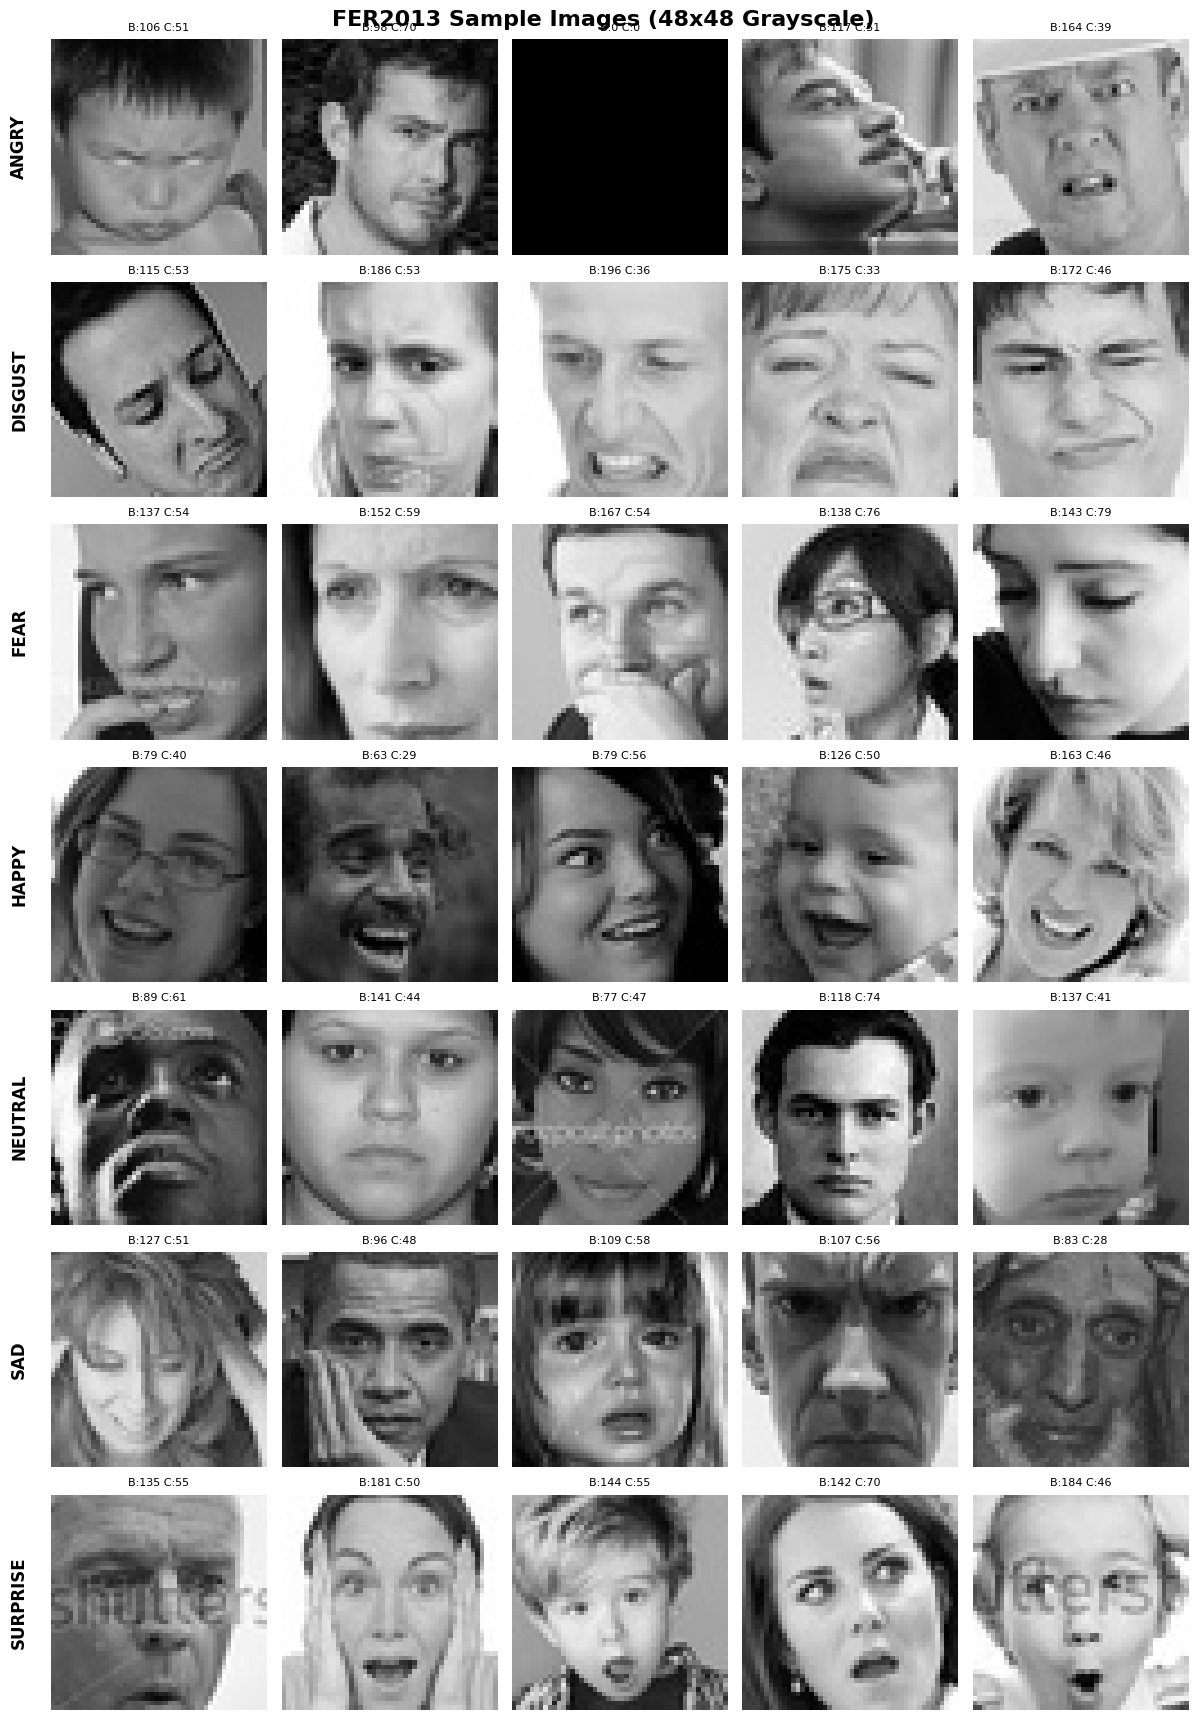

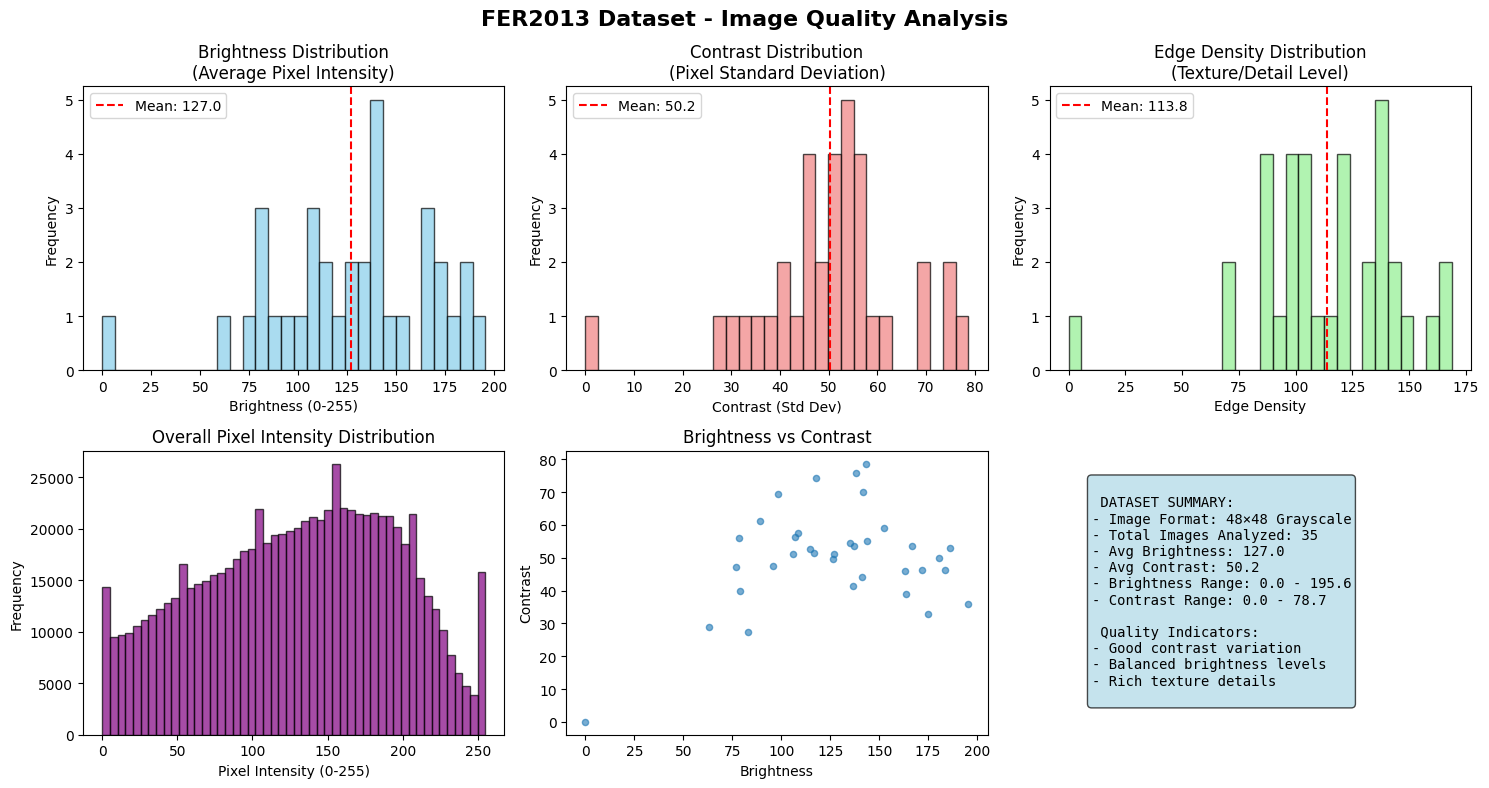

In [35]:
print("\nRunning image samples analysis...")
image_stats = analyze_image_samples()